This file performs a classification using KNN + PCA on the face images in *sklearn.datasets.fetch_olivetti_faces*. This is a collection of 400 grayscale images of 40 different subjects, with each subject having 10 different images.  The images are 64x64 pixels in size. This dataset is relatively clean and well-posed and it was created for face recognition tasks.

We compare the accuracy of classification with and without applying PCA. We also explore how the two hyperparameters, number of eigenvectors to keep in PCA and number of neighbors in KNN, affect the accuracy.

# sklearn Face Dataset Classification

In [143]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
import random

## Load datasets

In [144]:
''' load and preprocess images'''
# Load the Olivetti Faces dataset
faces_data = datasets.fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces_data.data
y = faces_data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

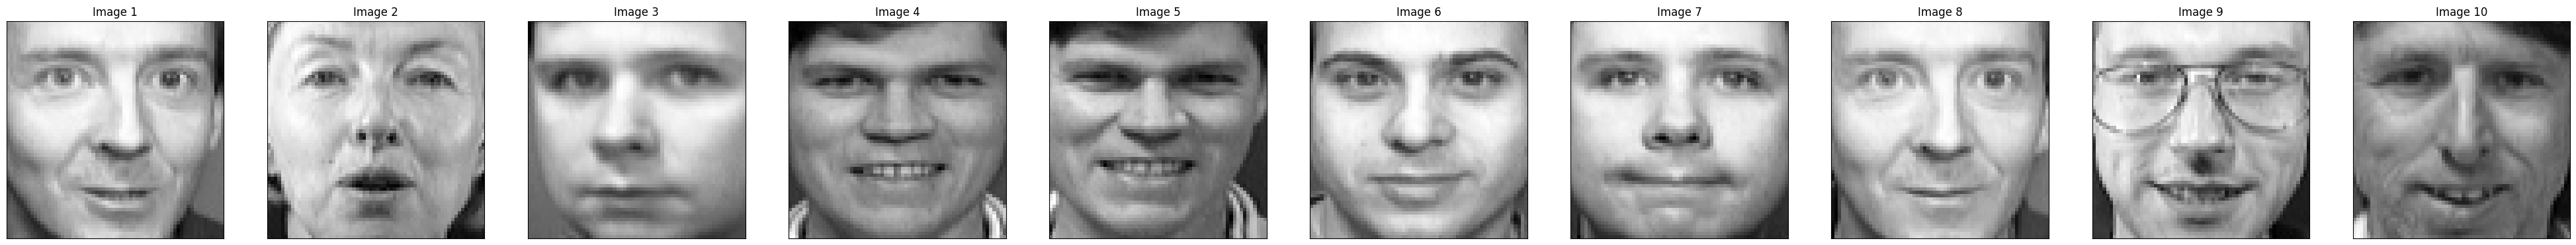

In [145]:
'''Show some images in this dataset'''
indices = random.sample(range(400), 10)
plt.figure(figsize=(50,500))
for i in range(10):
  img = X[indices[i]].reshape((64,64))
  plt.subplot(1,10,i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f'Image {i+1}')
  plt.xticks([])
  plt.yticks([])
plt.show()

## PCA

In [146]:
# Function to perform PCA using the Snapshot method
def PCA(images, num_eigenvectors):
  # Flatten images into 1D arrays
  # flattened_images = images.reshape(images.shape[0],-1)
  flattened_images = images

  # Calculate the mean face
  mean_face = np.mean(flattened_images, axis=0)

  # Subtract mean face from each image
  DT = flattened_images - mean_face

  # Compute D^T * D
  D = np.transpose(DT)
  DTD = np.matmul(DT,D) # Dt*D

  # Compute eigenvecotrs using the Snapshot method
  eigenvalues, eigenvectorsDTD = np.linalg.eig(DTD)
  eigenvectors = np.matmul(D,eigenvectorsDTD)

  # normalize eigenvectors to magnitude = 1
  eigenvectorsNorm = np.empty(eigenvectors.shape)
  norm = np.linalg.norm(eigenvectors, axis=0)  # compute the norm of each eigenvector
  for i in range(len(norm)):
    eigenvectorsNorm[:,i] = eigenvectors[:,i] / norm[i]  # normalize each eigenvector

  # Sort eigenvectors and eigenvalues in descending order
  sorted_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectorsNorm = eigenvectorsNorm[:, sorted_indices]

  # Select the top num_eigenvectors eigenvoectors
  selected_eigenvectors = eigenvectorsNorm[:, :num_eigenvectors]

  # Compute the fraction of total variance explained by each eigenvector
  total_variance = np.sum(eigenvalues)
  explained_variance_ratio = eigenvalues / total_variance

  return mean_face, selected_eigenvectors, explained_variance_ratio, eigenvalues

# Plot the Fraction of Total Variance vs. Number of Eigenvectors
def plot_variance_vs_eigenvectors(explained_variance_ratio):
  cumulative_variance_ratio = np.cumsum(explained_variance_ratio) # cumulative sum
  plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
  plt.title('Fraction of Total Variance vs. Number of Eigenvectors')
  plt.xlabel('Number of Eigenvectors')
  plt.ylabel('Fraction of Total Variance Explained')
  plt.show()

# Plot Normalized Variance (Eigenvalues) vs. Eigenvecotr Index
def plot_normalized_variance(eigenvalues):
  normalized_variance = eigenvalues / np.sum(eigenvalues)
  plt.plot(range(1, len(normalized_variance) + 1), normalized_variance, marker='o')
  plt.title('Normalized Variance (Eigenvalues) vs. Eigenvector Index')
  plt.xlabel('Eigenvector Index')
  plt.ylabel('Normalized Variance')
  plt.show()

# Display the First 5 Eigenfaces
def display_eigenfaces(mean_face, eigenvectors, num_eigenfaces=5):
  eigenfaces = eigenvectors[:, :num_eigenfaces]

  plt.figure(figsize=(15, 5))
  for i in range(num_eigenfaces):
      eigenface = eigenfaces[:, i].reshape(mean_face.shape)  # Reshape to match the original image dimensions
      eigenface_image = eigenface.reshape((64,64))  # Adjust dimensions based on image size
      plt.subplot(1, num_eigenfaces, i + 1)
      plt.imshow(eigenface_image, cmap='gray')
      plt.title(f'Eigenface {i + 1}')
      plt.axis('off')

  plt.tight_layout()
  plt.show()


In [147]:
''' Helper function to extract eigenface features '''
def extract_eigenface_features(images, mean_face, selected_eigenvectors):
  flattened_images = images.reshape(images.shape[0],-1)
  centered_images = flattened_images - mean_face
  eigenface_features = np.dot(centered_images, selected_eigenvectors)
  return eigenface_features


## Self-implemented KNN

In [148]:
class KNNClassifier:
  """
    K-Nearest Neighbors Classifier.

    Parameters:
    - k (int): Number of neighbors to consider during classification.
  """
  def __init__(self, k=3):
    self.k = k
    self.train_data = None
    self.train_labels = None

  def fit(self, train_data, train_labels):
    self.train_data = train_data
    self.train_labels = train_labels

  def predict(self, test_data):
    predictions = []
    for sample in test_data:
      # Calculate Euclidean distances between the test instance and all training instances
      # print(self.train_data.shape, sample.shape)
      distances = np.linalg.norm(self.train_data - sample, axis=1)

      # Find indices of k nearest neighbors
      nearest_neighbors_indices = np.argsort(distances)[:self.k]

      # Get labels of k nearest neighbors
      nearest_labels = self.train_labels[nearest_neighbors_indices]

      # Perform majority voting to determine the predicted label
      unique_labels, counts = np.unique(nearest_labels, return_counts=True)
      predicted_label = unique_labels[np.argmax(counts)]
      predictions.append(predicted_label)
    return np.array(predictions)

In [149]:
def train_and_test(train_features, human_train_label, test_features,human_test_label,k):
  knn_classifier = KNNClassifier(k=k)

  # Train the KNN classifier with the training data
  knn_classifier.fit(train_features, np.array(human_train_label))

  # Predict labels for the test data
  test_predictions = knn_classifier.predict(test_features)

  # Calculate and print the accuracy
  accuracy_value = accuracy_score(human_test_label, test_predictions)
  # print(f"KNN Classifier Accuracy: {accuracy_value * 100}%")
  return accuracy_value*100


## Experiments

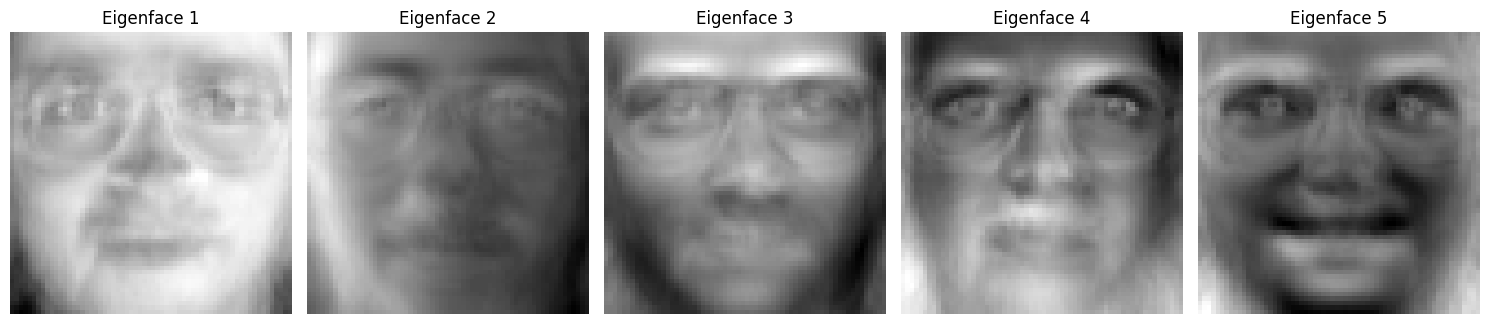

In [150]:
'''Perform PCA'''
n_eigens=35 # A carefully chose hyperparameter!
mean_face, selected_eigenvectors, explained_variance_ratio, eigenvalues = PCA(X_train, n_eigens)

'''Display the First 5 Eigenfaces'''
display_eigenfaces(mean_face, selected_eigenvectors, num_eigenfaces=5)

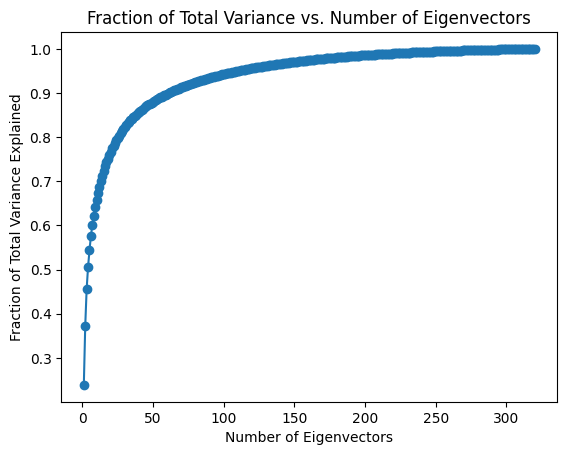

In [151]:
'''Plot the Fraction of Total Variance vs. Number of Eigenvecotrs'''
plot_variance_vs_eigenvectors(explained_variance_ratio)

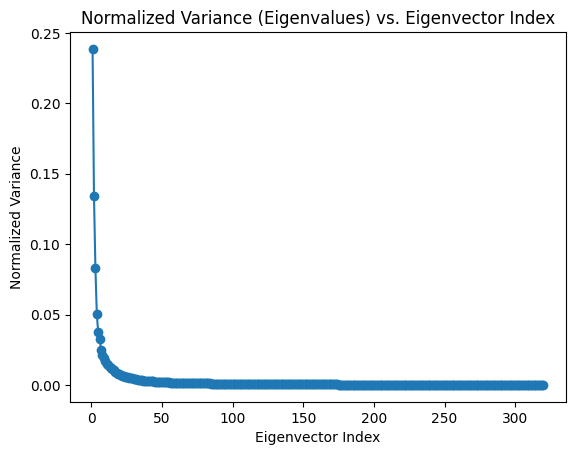

In [152]:
'''Plot Normalized Variance (Eigenvalues) vs. Eigenvector Index'''
plot_normalized_variance(eigenvalues)

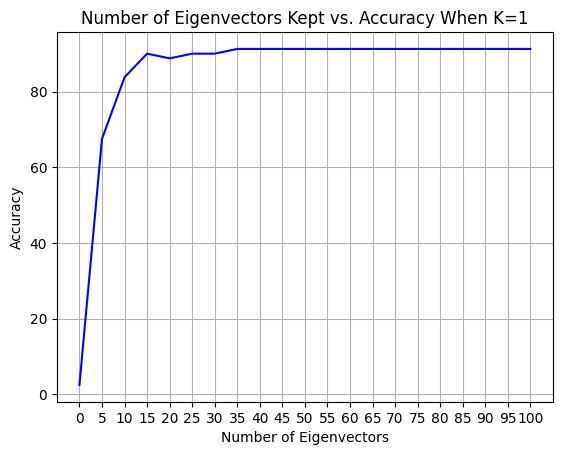

In [153]:
'''Explore how the number of eigenvectors kept affect the accuracy'''
ns = np.array(range(0,101,5))
accuracies = []
k=1
for n in ns:
  mean_face, selected_eigenvectors, explained_variance_ratio, eigenvalues = PCA(X_train, n)
  train_features = extract_eigenface_features(X_train, mean_face, selected_eigenvectors)
  test_features = extract_eigenface_features(X_test, mean_face, selected_eigenvectors)
  accuracies.append(train_and_test(train_features, y_train, test_features,y_test,k))

plt.plot(ns, accuracies, color="Blue")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Accuracy")
plt.xticks(ns)
plt.title(f"Number of Eigenvectors Kept vs. Accuracy When K={k}")
plt.grid()
plt.show()

In [154]:
'''Extract training and testing features from eigenvectors'''
train_features = extract_eigenface_features(X_train, mean_face, selected_eigenvectors)
test_features = extract_eigenface_features(X_test, mean_face, selected_eigenvectors)

number of eigenvectors kept: 100


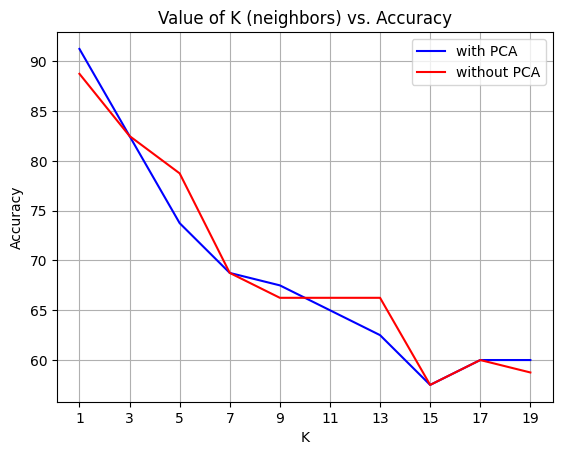

In [155]:
# Extract features without going through PCA
temp_train_set = X_train
temp_train_set = temp_train_set.reshape(temp_train_set.shape[0],-1)
temp_test_set = X_test
temp_test_set = temp_test_set.reshape(temp_test_set.shape[0],-1)


'''Investigate how accracy changes with value of K'''
accuracies_pca = []
accuracies = []
Ks = []
for i in range(10):
  k = 2*i+1
  Ks.append(k)
  accuracies_pca.append(train_and_test(train_features, y_train, test_features,y_test,k))
  accuracies.append(train_and_test(temp_train_set, y_train, temp_test_set, y_test,k))

print(f'number of eigenvectors kept: {n}')
plt.plot(Ks, accuracies_pca, color="Blue")
plt.plot(Ks, accuracies, color="Red")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(Ks)
plt.title("Value of K (neighbors) vs. Accuracy")
plt.grid()
plt.legend(["with PCA", "without PCA"])
plt.show()

In [156]:
'''Best accuracy after hyperparameter tuning'''
acc = train_and_test(train_features, y_train, test_features,y_test,1)
print(f'Accuracy of KNN classification with {n_eigens} eigenvectors when K=1: {acc}%')

Accuracy of KNN classification with 35 eigenvectors when K=1: 91.25%
